# Obesity project

## 1) Importation and cleaning

In [148]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso,SGDRegressor,LogisticRegression
from sklearn import svm,tree
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.model_selection import GridSearchCV

In [149]:
warnings.filterwarnings('ignore')

In [150]:
df=pd.read_csv("C:/Users/theo2/OneDrive/Documents/A4\Python for Data Analysis/PROJET FINAL/ObesityDataSet_raw_and_data_sinthetic.csv")

In [151]:
df=df.rename(columns = {"family_history_with_overweight": "genetic",
                          "FAVC": "high_calorific",
                          "FCVC": "vegetable",
                          "NCP": "frequence_meal",
                          "CAEC": "between_meal",
                          "CH2O": "water",
                          "SCC": "calories_monitoring",
                          "FAF": "physical_activity",
                          "TUE": "technology_time",
                          "CALC": "alcohol",
                          "MTRANS": "transportation",
                          "NObeyesdad": "obesity",
                          "SMOKE":"smoke",  
                         })

We apply the normal encoding on the columns that have 2 possible values

In [152]:
df['genetic'] = df['genetic'].map({'yes': 1, 'no': 0})
df['high_calorific'] = df['high_calorific'].map({'yes': 1, 'no': 0})
df['smoke'] = df['smoke'].map({'yes': 1, 'no': 0})
df['calories_monitoring'] = df['calories_monitoring'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['obesity'] = df['obesity'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1,'Overweight_Level_I': 2, 'Overweight_Level_II': 3,'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})



In [153]:
#df.drop_duplicates(inplace=True) : dire dans le rapport pk on le fait pas

Here we choose to apply the one-hot encoding on the 3 columns that have more than 2 possible values

In [154]:
from sklearn.preprocessing import OneHotEncoder

In [155]:
ohe=OneHotEncoder(categories='auto')

In [156]:
print(ohe)

OneHotEncoder()


In [157]:
variables_list=['between_meal', 'alcohol','transportation']

In [158]:
feature_arry=ohe.fit_transform(df[variables_list]).toarray()

In [159]:
feature_labels = ohe.get_feature_names(variables_list)

In [160]:
encoded_columns=pd.DataFrame(feature_arry,columns=feature_labels)

In [161]:
df=pd.concat([encoded_columns,df.drop(['between_meal', 'alcohol','transportation'],axis=1)],axis=1)

In [162]:
#df=pd.get_dummies(df, columns=['between_meal', 'alcohol','transportation'])

We normalize the data

In [163]:
from sklearn.preprocessing import Normalizer
test_df=df.obesity
df=df.drop('obesity',axis=1)
df.iloc[:,1:-1] = Normalizer().fit_transform(df.iloc[:,1:-1])

## 2) Implementation of the models

### Train-test split

In [164]:
test_df=test_df.to_frame()

In [165]:
from sklearn.model_selection import train_test_split

X=df
y=test_df.obesity  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

### First model

First we choose to apply a random forest model to the data, keeping all the features and columns

In [166]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


In [167]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9400630914826499


### Comparison of the models

We try several models and compare them to see which one gets the best accuracy

In [168]:
def Test_algo_Obesity(models, labels,train_x,test_x,train_y,test_y):
    dict_train_score={}
    dict_test_score={}
    for k in range(len(models)):
        model=models[k]
        model.fit(train_x,train_y)
        dict_train_score[labels[k]]=model.score(train_x,train_y)
        dict_test_score[labels[k]]=model.score(test_x,test_y)
        print("Test {} score ={: 0.3f}".format(labels[k],dict_test_score[labels[k]]))
    print("\nbest Model for Obesity dataset is {} with test score :{: 0.3f}".format(max(dict_test_score, key=dict_test_score.get),dict_test_score[max(dict_test_score, key=dict_test_score.get)]))
    return max(dict_test_score, key=dict_test_score.get)

In [169]:
models_liste=[svm.SVC(),tree.DecisionTreeClassifier(),RandomForestClassifier(n_estimators=500),KNeighborsClassifier(),LogisticRegression()]
labels_liste=["SVM","Desicion tree","RandomForest","KNeighbors","LogisticRegression"]

In [170]:
Test_algo_Obesity(models_liste, labels_liste,X_train, X_test, y_train, y_test)

Test SVM score = 0.383
Test Desicion tree score = 0.902
Test RandomForest score = 0.945
Test KNeighbors score = 0.634
Test LogisticRegression score = 0.339

best Model for Obesity dataset is RandomForest with test score : 0.945


'RandomForest'

### Features importance

Now let's see the importance of the different features on the model

In [171]:
import numpy as np

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [172]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

In [173]:
import matplotlib.pyplot as plt

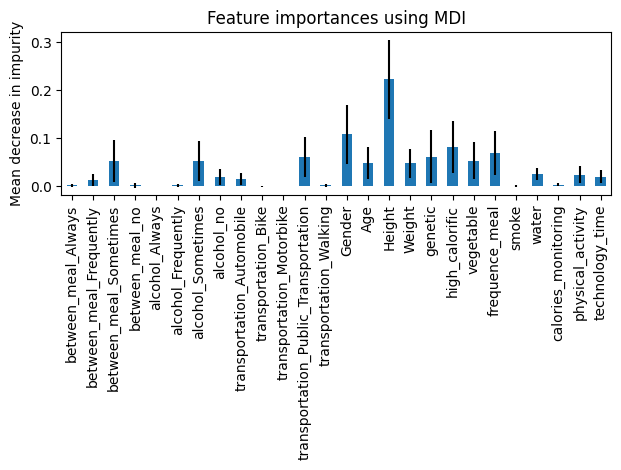

In [174]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that smoke, calories_monitoring have almost no impact, that's why we will remove them : thus, we can ask fewer questions to the sample.

Let's remove these columns and analyze the results

In [175]:
from sklearn.model_selection import train_test_split

X=df.drop(['smoke','calories_monitoring'],axis=1)
y=test_df.obesity  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [176]:
Test_algo_Obesity(models_liste, labels_liste,X_train, X_test, y_train, y_test)

Test SVM score = 0.394
Test Desicion tree score = 0.891
Test RandomForest score = 0.942
Test KNeighbors score = 0.604
Test LogisticRegression score = 0.345

best Model for Obesity dataset is RandomForest with test score : 0.942


'RandomForest'

We see that by removing these 2 columns, we even get a better accuracy

### Grid search

We try the random forest model (the best so far) with different hyperparameters and see which ones are the best

In [177]:
param_grid={"max_depth":[k for k in range(5)],"n_estimators":[k for k in range(21,24)],"criterion":["gini","entropy","log_loss"]}
grid=GridSearchCV(RandomForestClassifier(),param_grid)
grid.fit(X_train,y_train)
print('grid params best model',grid.best_params_)
print('grid score best model',grid.best_score_)
best_model=grid.best_estimator_
print('test score best model', best_model.score(X_test,y_test))

grid params best model {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 22}
grid score best model 0.8388845625286303
test score best model 0.8201892744479495
